# Демченко Георгий Павлович БПИ-235, Task_03


## Загрузка данных и подключение библиотек, определение методов

In [1]:
# Ссылка на папку яндекс диска, где располагаются необходимые данные - https://disk.yandex.ru/d/ZAhRwhLPBPmgWw
import requests
from urllib.parse import urlencode

url_to_data = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' + urlencode(dict(public_key = 'https://disk.yandex.ru/d/ZAhRwhLPBPmgWw'))
response = requests.get(url_to_data)
download_url = response.json()['href']

download_response = requests.get(download_url)
with open('USDA_Task03.zip', 'wb') as f:
    f.write(download_response.content)

In [ ]:
from osgeo import gdal, ogr, osr, gdal_array, gdalconst
from PIL import Image
from PIL.TiffTags import TAGS
import matplotlib as mplt
import matplotlib.pyplot as plt
import numpy as np
!unzip -o USDA_Task03.zip
%pip install rasterio
%pip install -U mapclassify
%matplotlib inline
import mapclassify
import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist

In [4]:
# @title Определим метод для полученния данных формата .tif
gdal.UseExceptions()

def GetDataFromFile(fileName):
  pathToData = f'USDA_Task03/USDA/{fileName}'
  tmp_ds = None
  try:
    tmp_ds = gdal.Open(pathToData)
  except RuntimeError:
    print("The file will not be downloaded due to an runtime error.")
  return tmp_ds

In [5]:
# @title Определим метод для преобразования данных формата .tif в список матриц np.array по слоям растровых данных
def ConvertDataToArray(dataSet):
  lstWithArrays = [np.array(dataSet.GetRasterBand(i + 1).ReadAsArray()) for i in range(dataSet.RasterCount)]
  return lstWithArrays

In [8]:
# @title Сохраним данные файлов Band01.tif, Band02.tif, Croptypes.tif
band1_ds = GetDataFromFile("Band01.tif")
band2_ds = GetDataFromFile("Band02.tif")
croptypes_ds = GetDataFromFile("Croptypes.tif")
band1_array = ConvertDataToArray(band1_ds)[0]
band2_array = ConvertDataToArray(band2_ds)[0]
croptypes_array = ConvertDataToArray(croptypes_ds)[0]

## Task №1

In [108]:
# Составим словарь с ключами - значениями пикселей, значениями - количеством пикселей с данным значением
dct_band1_vals = {}
for i in range(len(band1_array)):
  for j in range(len(band1_array[i])):
    cur_val = band1_array[i][j]
    if cur_val not in dct_band1_vals.keys():
      dct_band1_vals[cur_val] = 0
    dct_band1_vals[cur_val] += 1

most_used_pixelVal = sorted(dct_band1_vals.items(), key = lambda data: data[1], reverse = True)[0][0]
cnt_mu_pixel = np.count_nonzero(band2_array[-1] == most_used_pixelVal)

print(f"Значение самого часто-встречающегося пикселя в файле Band01.tif - {most_used_pixelVal}")
print(f"В последней строке матрицы файла Band02.tif пиксель {most_used_pixelVal} встречается {cnt_mu_pixel} раз")

Значение самого часто-встречающегося пикселя в файле Band01.tif - 8434
В последней строке матрицы файла Band02.tif пиксель 8434 встречается 1 раз


## Task №2

In [109]:
# Функция для преобразования индексов пикселя из матрицы растровых данных в координаты пикселя
def ConvertMatrixCoordsToRaster(dataSet, i, j):
  (upper_left_x, x_size, x_rotation, upper_left_y, y_rotation, y_size) = dataSet.GetGeoTransform()
  x_cur = j * x_size + upper_left_x
  y_cur = i * y_size + upper_left_y
  return (x_cur, y_cur)

merged_bool_array = np.logical_and(band1_array < 8500, band2_array > 11000)
lst_coords_px = [(i, j) for i in range(len(merged_bool_array)) for j in range(len(merged_bool_array[i])) if merged_bool_array[i][j]]
print("Коориданты искомых пикселей:")
for i in range(len(lst_coords_px)):
  print(f"[{i + 1}]. Координаты пикселя в матрице: {lst_coords_px[i]}\n     Координаты пикселя в растре: {ConvertMatrixCoordsToRaster(band1_ds, lst_coords_px[i][0], lst_coords_px[i][1])}\n")

Коориданты искомых пикселей:
[1]. Координаты пикселя в матрице: (125, 1111)
     Координаты пикселя в растре: (329840.0, 4237600.0)

[2]. Координаты пикселя в матрице: (1061, 1217)
     Координаты пикселя в растре: (333020.0, 4209520.0)

[3]. Координаты пикселя в матрице: (1115, 1044)
     Координаты пикселя в растре: (327830.0, 4207900.0)

[4]. Координаты пикселя в матрице: (1292, 1840)
     Координаты пикселя в растре: (351710.0, 4202590.0)

[5]. Координаты пикселя в матрице: (1333, 593)
     Координаты пикселя в растре: (314300.0, 4201360.0)

[6]. Координаты пикселя в матрице: (1435, 561)
     Координаты пикселя в растре: (313340.0, 4198300.0)

[7]. Координаты пикселя в матрице: (1610, 1900)
     Координаты пикселя в растре: (353510.0, 4193050.0)



## Task №3

In [110]:
# Определим функцию для сжатия массива по заданным условиям
def CompressArray(lstWithData):
  compressed_lst = []
  length, width = lstWithData.shape
  for i in range(0, length, 2):
    tmp_lst = []
    for j in range(0 , width, 2):
      lst_cur_idx = [(i, j), (i, j + 1), (i + 1, j), (i + 1, j + 1)]
      mean_val = np.mean(np.array([lstWithData[idx_data[0]][idx_data[1]] for idx_data in lst_cur_idx if (idx_data[0] < length and idx_data[1] < width)]))
      tmp_lst.append(mean_val)
    compressed_lst.append(tmp_lst)
  return np.array(compressed_lst, dtype = float)


# Заметим, что предоставленный в файле пример был неверный, по условию "значение пикселя принимаем за среднее арифметическое значений пикселей в соответствующем квадрате."
# При этом неполный квадрат с двумя элементами считали как (17+18)/4
# Описанная функция считает значение пикселя по кол-ву цифр в квадрате, подобные ситуации будут высчитываться как (17 + 18)/2
comperssed_band1_array = CompressArray(band1_array)

print(f"Размеры исходного массива: length = {band1_array.shape[0]}, width = {band1_array.shape[1]}")
print(f"Размеры полученного массива: length = {comperssed_band1_array.shape[0]}, width = {comperssed_band1_array.shape[1]}")
print("Полученный сжатый массив файла Band01.tif:")
print(comperssed_band1_array)

Размеры исходного массива: length = 2644, width = 2891
Размеры полученного массива: length = 1322, width = 1446
Полученный сжатый массив файла Band01.tif:
[[ 7727.    7731.75  7757.5  ...  8468.5   7929.25  7912.  ]
 [ 8565.25  8575.25  8512.5  ...  8548.    7979.25  7968.  ]
 [ 8839.75  8829.75  8858.25 ...  8605.25  8011.75  8043.  ]
 ...
 [10106.75 10020.   10010.25 ...  8499.    8741.75  8867.5 ]
 [ 9863.    9875.75  9919.   ...  8544.75  8561.5   8539.5 ]
 [ 8739.5   8754.25  8769.25 ...  8748.    8615.75  8566.  ]]


## Task №4

In [111]:
band1_even_array = ((band1_array + 1) % 2)
width = band1_array.shape[1]

cnt_1 = 0
for i in range(len(band1_even_array)):
  if len(band1_even_array[i]) - 2 * np.count_nonzero(band1_even_array[i]) > 0:
    cnt_1 += 1
cnt_2 = 0
for i in range(width):
  if (band1_array[0][i] % 10 == 0) and (band1_array[0][i] < band1_array[1][i]):
    cnt_2 += 1

print(f"Искомое количество пикселей = {cnt_1 * cnt_2}")

Искомое количество пикселей = 215828


## Task №5

In [6]:
# @title Загрузим данные о слоях с красным и инфрокарсным спектром
band4_ds = GetDataFromFile("Band04.tif")
band4_array = ConvertDataToArray(band4_ds)[0]
band5_ds = GetDataFromFile("Band05.tif")
band5_array = ConvertDataToArray(band5_ds)[0]
aspect_ds = rasterio.open("USDA_Task03/USDA/Band04.tif")

In [103]:
# @title Создадим np.array с данным NDVI у пикселей с corn и alfalfa
corn_alfalfa_bool_array = np.logical_or(croptypes_array == 1, croptypes_array == 36)

NDVI_array = (band5_array - band4_array)/(band4_array + band5_array)
length = NDVI_array.shape[0]
width = NDVI_array.shape[1]
for i in range(length):
  for j in range(width):
    if (not corn_alfalfa_bool_array[i][j]):
      NDVI_array[i][j] = np.nan

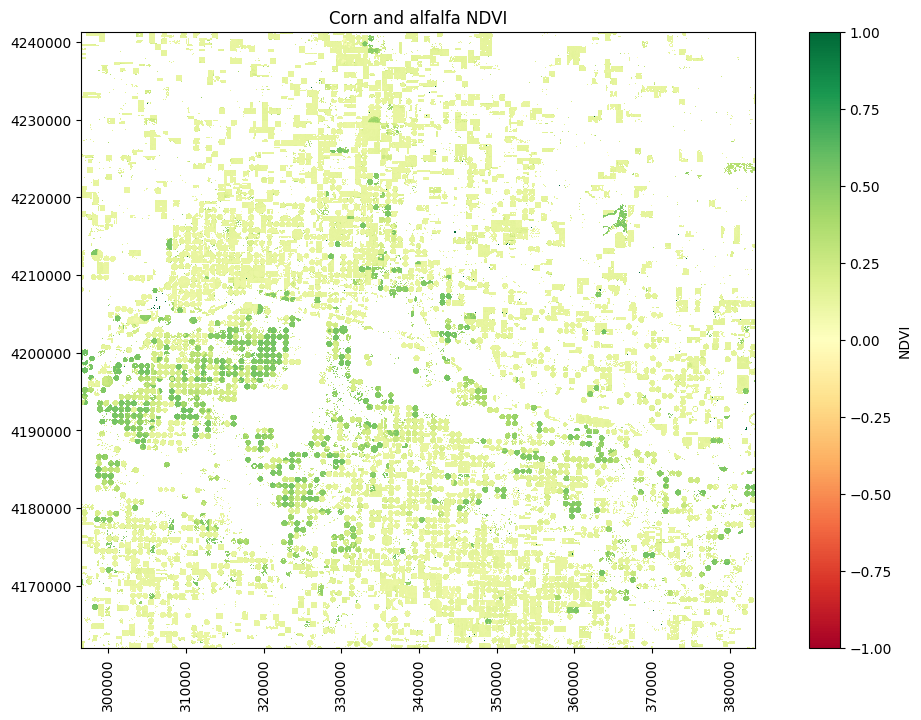

In [104]:
# @title Выведем полученные данные на график
ext = [aspect_ds.bounds.left,
       aspect_ds.bounds.right,
       aspect_ds.bounds.bottom,
       aspect_ds.bounds.top]

fig, ax = plt.subplots(1, 1, figsize=(14,8))
plt.imshow(NDVI_array,extent=ext, cmap = 'RdYlGn', interpolation='nearest')
plt.clim(-1, 1)
plt.title("Corn and alfalfa NDVI")
plt.colorbar(label = "NDVI");
ax=plt.gca();
ax.ticklabel_format(useOffset=False, style='plain')
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

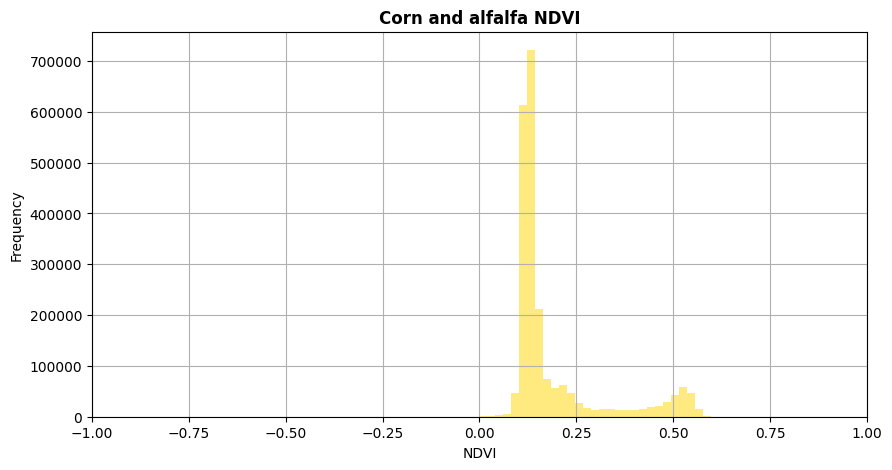

In [105]:
# @title Построим гистограмму распределения NDVI
fig, ax2 = plt.subplots(figsize=(10, 5))
plt.xlim(-1, 1)
show_hist(NDVI_array, bins=200, histtype='stepfilled',
          lw=1.0, stacked=False, alpha=0.5, ax = ax2, title = "Corn and alfalfa NDVI");
ax2.set_xlabel("NDVI");
ax2.get_legend().remove()

## Task №6

In [106]:
# @title По полученным ранее данным создадим np.array с NDVI у произвольных 50% пикселей corn и alfalfa
import random
corn_alfalfa_bool_array = np.logical_or(croptypes_array == 1, croptypes_array == 36)

lst_corn_alf_idx = []

NDVI_random_array = np.array((band5_array - band4_array)/(band4_array + band5_array), dtype = float)
length = NDVI_random_array.shape[0]
width = NDVI_random_array.shape[1]
for i in range(length):
  for j in range(width):
    if (not corn_alfalfa_bool_array[i][j]):
      NDVI_random_array[i][j] = np.nan
    else:
      lst_corn_alf_idx.append((i, j))


lst_random_idx = random.sample(lst_corn_alf_idx, int(len(lst_corn_alf_idx )/ 2))
for i in range(len(lst_random_idx)):
  del_i, del_j = lst_random_idx[i]
  NDVI_random_array[del_i, del_j] = np.nan

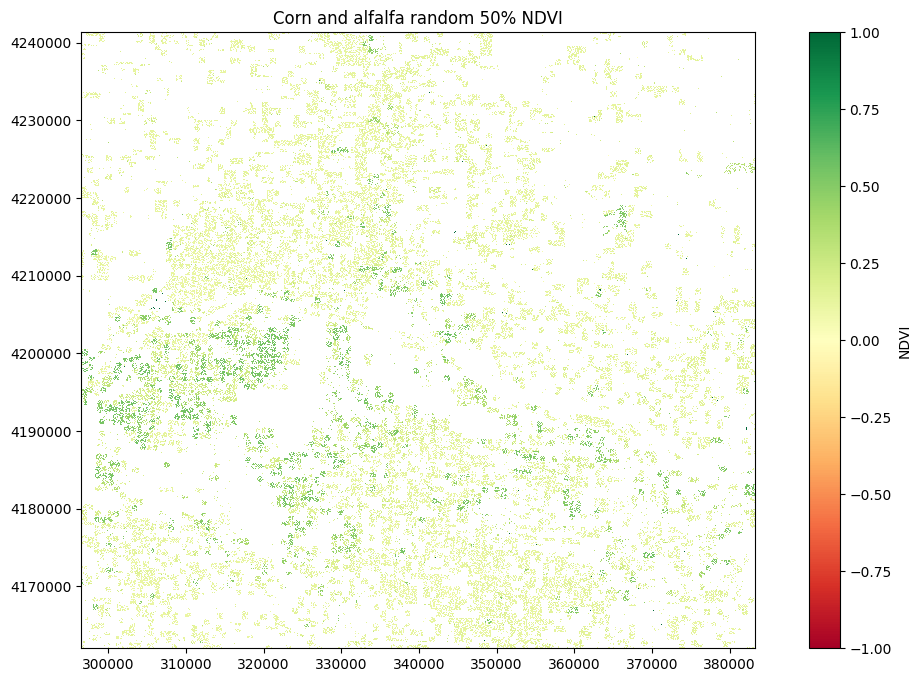

In [107]:
# @title Выведем полученные данные на график
ext = [aspect_ds.bounds.left,
       aspect_ds.bounds.right,
       aspect_ds.bounds.bottom,
       aspect_ds.bounds.top]

fig3, ax3 = plt.subplots(figsize=(14,8))
plt.imshow(NDVI_random_array,extent=ext,cmap = 'RdYlGn', interpolation='nearest')
plt.clim(-1, 1)
plt.title("Corn and alfalfa random 50% NDVI")
plt.colorbar(label = "NDVI");
ax3=plt.gca();
ax3.ticklabel_format(useOffset=False, style='plain')
rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)

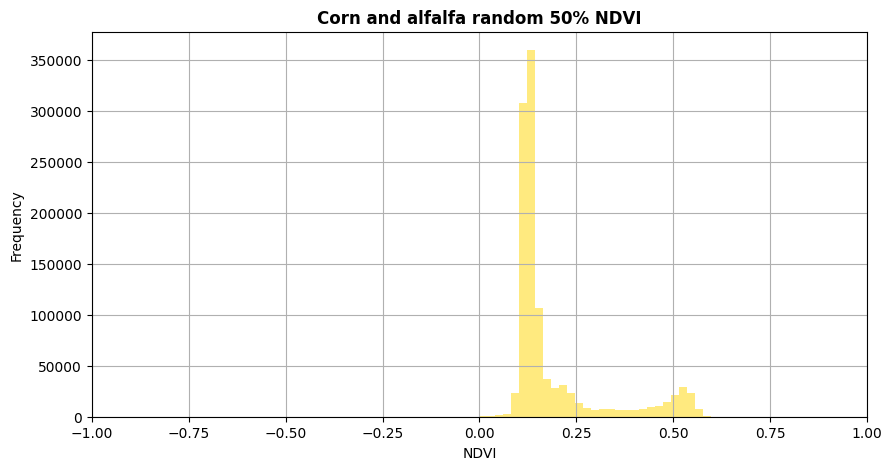

In [102]:
# @title Построим гистограмму распределения NDVI
fig, ax4 = plt.subplots(figsize=(10, 5))
plt.xlim(-1, 1)
show_hist(NDVI_random_array, bins=200, histtype='stepfilled',
          lw=1.0, stacked=False, alpha=0.5, ax = ax4, title = "Corn and alfalfa random 50% NDVI");
ax4.set_xlabel("NDVI");
ax4.get_legend().remove()

## Task №7

In [143]:
# @title Сохраним файл Croptypes.tif.vat.dbf в pandas DataFrame
import pandas as pd
import geopandas as gpd
%pip install simpledbf
import simpledbf
from simpledbf import Dbf5

In [144]:
coprtypes_dbf = Dbf5("USDA_Task03/USDA/Croptypes.tif.vat.dbf")
croptypes_df = coprtypes_dbf.to_dataframe()
croptypes_df.head()

,VALUE,RED,GREEN,BLUE,CLASS_NAME,OPACITY
0,0,0.0,0.000,0.000,Background,0.0
1,1,1.0,0.827,0.000,Corn,1.0
2,2,1.0,0.149,0.149,Cotton,1.0
3,3,0.0,0.659,0.894,Rice,1.0
4,4,1.0,0.620,0.043,Sorghum,1.0


In [145]:
#Обработаем строки с nan в столбце "CLASS_NAME"
croptypes_df["CLASS_NAME"] = croptypes_df["CLASS_NAME"].fillna("N/a")
# @title Проанализируем полученные данные и поймём какие классы культур нам нужны
croptypes_df["CLASS_NAME"].unique()

array(['Background', 'Corn', 'Cotton', 'Rice', 'Sorghum', 'Soybeans',
       'Sunflower', 'N/a', 'Peanuts', 'Tobacco', 'Sweet Corn',
       'Pop or Orn Corn', 'Mint', 'Barley', 'Durum Wheat', 'Spring Wheat',
       'Winter Wheat', 'Other Small Grains', 'Dbl Crop WinWht/Soybeans',
       'Rye', 'Oats', 'Millet', 'Speltz', 'Canola', 'Flaxseed',
       'Safflower', 'Rape Seed', 'Mustard', 'Alfalfa',
       'Other Hay/Non Alfalfa', 'Camelina', 'Buckwheat', 'Sugarbeets',
       'Dry Beans', 'Potatoes', 'Other Crops', 'Sugarcane',
       'Sweet Potatoes', 'Misc Vegs & Fruits', 'Watermelons', 'Onions',
       'Cucumbers', 'Chick Peas', 'Lentils', 'Peas', 'Tomatoes',
       'Caneberries', 'Hops', 'Herbs', 'Clover/Wildflowers',
       'Sod/Grass Seed', 'Switchgrass', 'Fallow/Idle Cropland', 'Forest',
       'Shrubland', 'Barren', 'Cherries', 'Peaches', 'Apples', 'Grapes',
       'Christmas Trees', 'Other Tree Crops', 'Citrus', 'Pecans',
       'Almonds', 'Walnuts', 'Pears', 'Clouds/No Data', 'D

In [195]:
# @title Составим по полученному DataFrame словарь нужных данных: ключи - имёна классов, значения -  индексы класса, занимаемая площадь, процент занимаемой площади
set_uncceptable_classes_names = set(["Forest", "Deciduous Forest", "Evergreen Forest", "Mixed Forest",
                                 "Shrubland", "Wetlands", "Herbaceous Wetlands", "Woody Wetlands",
                                 "Developed", "Developed/Low Intensity", "Developed/Med Intensity", "Developed/High Intensity", "Developed/Open Space",
                                 "Open Water", "Barren", "Perennial Ice/Snow",  "N/a"])


# Функция для вычисления площади, занимаемой культурой
def CountAreaOfCultureClass(class_idx):
  area = np.count_nonzero(croptypes_array == class_idx) * 30**2 /(10**6)
  return area


# Те агрокультуры, данные о которых есть в растре, но площадь которых равно 0 учитывать не будем
overall_area_km2 = croptypes_array.shape[0] * croptypes_array.shape[1] * 30**2 / (10**6)
overal_agricultural_area = 0

dct_agriculture_land_cover = {}
for i in range(len(croptypes_df)):
  cur_value = croptypes_df["VALUE"].iloc[i]
  cur_class_name = croptypes_df["CLASS_NAME"].iloc[i]
  if (cur_class_name in set_uncceptable_classes_names):
    continue
  cur_area = CountAreaOfCultureClass(cur_value)
  if (cur_area == 0):
    continue
  cur_percent = round((100 * cur_area/overall_area_km2), 5)
  dct_agriculture_land_cover[cur_class_name ] = [cur_value, cur_area, cur_percent]
  overal_agricultural_area += cur_area

In [200]:
# @title Выведем необходимые данные

print(f"Общая площадь участка: {overall_area_km2} km^2")
print(f"Общее число сельскохозяйственных культур(с ненулевой площадью): {len(dct_agriculture_land_cover)}")
print(f"Площадь, занимаемая сельскохозяйственными культурами: {overal_agricultural_area} km^2")
print(f"Процент от общей площади, занимаемой сельхоз. культурами: {round((100 * overal_agricultural_area/ overall_area_km2), 2)}%")
print("Данные каждой культуры:")
cnt = 1
for key in dct_agriculture_land_cover.keys():
  print(f"[{cnt}].Культура - {key}\n    Занимаемая площадь - {dct_agriculture_land_cover[key][1]} km^2\n    Процент занимаемой площади - {dct_agriculture_land_cover[key][2]}%")
  cnt += 1

Общая площадь участка: 6879.4236 km^2
Общее число сельскохозяйственных культур(с ненулевой площадью): 23
Площадь, занимаемая сельскохозяйственными культурами: 6541.902 km^2
Процент от общей площади, занимаемой сельхоз. культурами: 95.09%
Данные каждой культуры:
[1].Культура - Corn
    Занимаемая площадь - 1610.7948 km^2
    Процент занимаемой площади - 23.41468%
[2].Культура - Cotton
    Занимаемая площадь - 1.8846 km^2
    Процент занимаемой площади - 0.02739%
[3].Культура - Sorghum
    Занимаемая площадь - 667.206 km^2
    Процент занимаемой площади - 9.69857%
[4].Культура - Soybeans
    Занимаемая площадь - 42.2235 km^2
    Процент занимаемой площади - 0.61377%
[5].Культура - Sunflower
    Занимаемая площадь - 1.332 km^2
    Процент занимаемой площади - 0.01936%
[6].Культура - Barley
    Занимаемая площадь - 0.0117 km^2
    Процент занимаемой площади - 0.00017%
[7].Культура - Winter Wheat
    Занимаемая площадь - 1310.607 km^2
    Процент занимаемой площади - 19.05112%
[8].Культура 